# CRPO Code for meta algorithm

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Frozen_lake_Meta_SRL'

/content/drive/MyDrive/Frozen_lake_Meta_SRL


In [ ]:
!cp /content/drive/MyDrive/acrobot/utils/math_utils.py /content
!cp /content/drive/MyDrive/acrobot/utils/torch_utils.py /content
!cp /content/drive/MyDrive/acrobot/utils/atari_wrapper.py /content

In [ ]:
import collections
import copy
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
import math_utils 

In [ ]:
# Generate random map
def generate_random_map(size=4, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == "G":
                        return True
                    if res[r_new][c_new] != "H":
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        res[0][0] = "S"
        res[-1][-1] = "G"
        valid = is_valid(res)
    return ["".join(x) for x in res]


In [ ]:
map_name1 = generate_random_map()
# map_name2 = generate_random_map()
print(map_name1)


# np.save('map1', map_name1)

['SFHF', 'FFHF', 'FFFF', 'FFFG']


In [ ]:
map_name = ['SHHF', 'FFHF', 'FFFF', 'FFFG']
size = 4
def is_valid(res):
  frontier, discovered = [], set()
  frontier.append((0, 0))
  while frontier:
      r, c = frontier.pop()
      if not (r, c) in discovered:
          discovered.add((r, c))
          directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
          for x, y in directions:
              r_new = r + x
              c_new = c + y
              if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                  continue
              if res[r_new][c_new] == "G":
                  return True
              if res[r_new][c_new] != "H":
                  frontier.append((r_new, c_new))
  return False

print(is_valid(map_name))

# np.save('maps_high_sim/map11', map_name)

True


In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

def softmax_policy_model(observation, policy_model):
    """Compute softmax values for each sets of scores in x."""
    x = policy_model[observation,:]
    # return np.exp(x) / np.sum(np.exp(x), axis=0)
    probs = softmax(x)
    return probs

def softmax_policy_model_return(policy_model):
  orig_policy_model = np.zeros((16,4))
  for i in range(16):
    orig_policy_model[i,:] = softmax_policy_model(i, policy_model)

  return orig_policy_model

def sample_actions(observation, policy_model):
  x = softmax_policy_model(observation, policy_model)
  probabilities = x.tolist()
  action = np.random.choice(np.arange(0, 4), p = x.tolist())
  return action

def flatten(l):
    return [item for sublist in l for item in sublist]

def reward_function(observation, env):
  # The agent is rewarded +2 to reach the goal, -1 for the hole and 1 for the F.

  r = int(observation/4)   # Which row is the agent in?
  c = observation%4        # Which column is the agent in?
  desc = env.desc          # Getting the map of the current configuration

  if desc[r,c] == b'S':
    reward = 0.0
  elif desc[r,c] == b'F':
    reward = 0.0            # Reward is 1 when the agent lands on the frozen lake part
  elif desc[r,c] == b'H':
    reward = 0.0           
  elif desc[r,c] == b'G':
    reward = 2.0             

  return reward

def constraint_I(observation, env):
  # cost if the agent lands in the hole
    r = int(observation/4)
    c = observation%4
    desc = env.desc

    if desc[r,c] == b'H':
      cost = 1
    else:
      cost = 0.0

    return cost

def step(action, env):
  new_state, _, done, _ = env.step(action)
  hole = False
  r = int(new_state/4)
  c = new_state%4
  desc = env.desc
  
  # If the agent reaches the hole or the goal, the environment is reset
  if desc[r,c] == b'H':
    done = True
    hole = True
  elif desc[r,c] == b'G':
    done = True
  else:
    done = False

  return new_state, done, hole


def sample_trajectories(env, gamma, beta, episodes, length, policy_model, qtable_reward, 
                        qtable_cost, d_threshold, N_0, alpha):
    # Sample trajectories
    paths = []
    episodes_so_far = 0
    k = 0

    while episodes_so_far < episodes:
        k += 1
        
        episodes_so_far += 1
        states, actions, rewards, costs = [], [], [], []
        state_action_buffer = []
        state = env.reset()
        length_so_far = 0
        done = False
        hole = False
        
        while not done:
        # while length_so_far < length:
          states.append(state)
          action = sample_actions(state, policy_model)
          new_state, done, hole = step(action, env)
          new_action = sample_actions(new_state, policy_model)
          actions.append(action)
  
          state_action_pair = [state, action]
          state_action_buffer.append(state_action_pair)
            
          reward = reward_function(new_state, env)
          cost = constraint_I(new_state, env)
  
          rewards.append(reward)
          costs.append(cost)
  
          # Update Q(s,a) for the reward
          qtable_reward[state, action] = qtable_reward[state, action] + \
                                  beta * (reward + gamma * qtable_reward[new_state, new_action] - qtable_reward[state, action])
  
          # Update Q(s,a) for the cost
          qtable_cost[state, action] = qtable_cost[state, action] + \
                                  beta * (cost + gamma * qtable_cost[new_state, new_action] - qtable_cost[state, action])
  
          # Update our current state
          state = new_state
          
          if done: 
              # alpha = alpha/(k**2)
              state = env.reset()

              # Calculate the Q-value of all the state actions in the buffer
              q_cost = 0
              rho_j = 1/(len(state_action_buffer))
                
              for j in range(len(state_action_buffer)):
                state_value = state_action_buffer[j][0]
                action_value = state_action_buffer[j][1]
                q_cost += rho_j*qtable_cost[state_value, action_value]
              state_action_buffer = []
              if q_cost <= d_threshold:    # Update the policy to maximize the reward  
                policy_model = policy_model + alpha*(qtable_reward/(1-gamma))
              else:    # Update the policy to minimize the cost
                policy_model = policy_model - alpha*(qtable_cost/(1-gamma))

          # length_so_far += 1
        

        path = {"observations": states,
                "actions": actions,
                "rewards": rewards,
                "costs": costs}
        paths.append(path)

        

    observations = flatten([path["observations"] for path in paths])
    discounted_rewards = flatten([math_utils.discount(path["rewards"], gamma) for path in paths])
    total_reward = sum(flatten([path["rewards"] for path in paths])) / episodes
    ## add for cost
    discounted_costs = flatten([math_utils.discount(path["costs"], gamma) for path in paths])
    total_cost = sum(flatten([path["costs"] for path in paths])) / episodes
    # discounted_costs2 = flatten([math_utils.discount(path["costs2"], gamma) for path in paths])
    # total_cost2 = sum(flatten([path["costs2"] for path in paths])) / episodes


    actions = flatten([path["actions"] for path in paths])

    return total_reward, total_cost, policy_model, qtable_reward, qtable_cost


# Random initializations

In [ ]:
def main(num_tasks):
    # map_name = generate_random_map()
    # Giving a custom map
    map_name = np.load('maps_high_sim/map'+str(num_tasks)+'.npy')
    map_name = map_name.tolist()
    env = gym.make("FrozenLake-v1",desc= map_name, is_slippery=True)

    # np.save('map'+str(num_tasks)+'.npy', map_name)

    ## Hyperparameter
    beta = 0.3    # value function learning rate for the critic
    alpha = 0.03  # Keeping a constant learning rate
    gamma = 0.98             # Discount factor
    # episodes = 10 #10 
    episodes = 3 #10
    length = 100  #50       # Length of the sample trajectories, maybe we can change this

    STEP = 20

    # Set the threshold
    d_threshold = 0.3

    # Initialize the Q-tables and the policy for the task at hand
    qtable_reward = np.zeros((16, 4))
    qtable_cost = np.zeros((16, 4))
    policy_model = np.ones((16, 4))
    # policy_model = np.load('data_high_sim/policy8.npy')


    N_0 = []

    ## Training the policy
    iterations = []
    results = []
    violations = []
    results_avg = []
    violations_avg = []
    result_avg = 0
    violation_avg = 0
  
    for iteration in range(STEP):
      result, violation, policy_model_out, value_model, cost_model = sample_trajectories(env, gamma, beta, episodes, length,
                                                                                         policy_model, qtable_reward, qtable_cost, d_threshold, N_0, alpha)

      
      
      policy_model = policy_model_out
      qtable_cost = cost_model
      qtable_reward = value_model


      iterations.append(iteration)
      results.append(result)
      violations.append(violation)


      result_avg = (iteration/(iteration+1)) * result_avg + (1/(iteration+1)) * result
      violation_avg = (iteration / (iteration + 1)) * violation_avg + (1 / (iteration + 1)) * (violation)
      

      results_avg.append(result_avg)
      violations_avg.append(violation_avg)


    constraint1 = [d_threshold for i in range(STEP)]
    # constraint2 = [d_threshold for i in range(STEP)]

    plt.figure()
    plt.plot(iterations, results, color='r', linestyle='-', label='C-TRPO reward')
    plt.plot(iterations, violations, color='b', linestyle='-', label='C-TRPO cost')
    
    # plt.plot(iterations, results_avg, color='r', linestyle='-.')
    # plt.plot(iterations, violations_avg, color='b', linestyle='-.')
    # # plt.plot(iterations, violations2_avg, color='g', linestyle='-.', label='C-TRPO average cost2')

    plt.plot(iterations, constraint1, color='b', linestyle='--')
    # plt.plot(iterations, constraint2, color='g', linestyle='--')
    plt.legend(loc='upper left')
    plt.xlabel('# of Episodes')
    plt.ylabel('Reward/Cost')
    plt.title('Task'+str(num_tasks))
    plt.show()
    # np.save('data_high_sim/rewards'+str(num_tasks)+'.npy',results)
    # np.save('data_high_sim/costs'+str(num_tasks)+'.npy',violations)
    
    
    orig_policy_model = softmax_policy_model_return(policy_model_out)

    return policy_model_out, results, violations


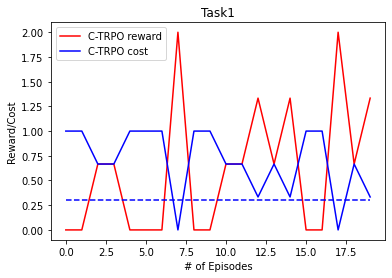

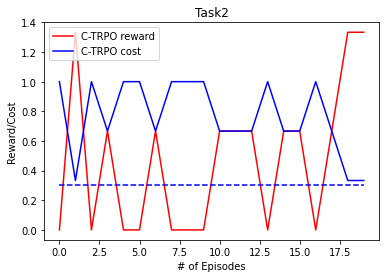

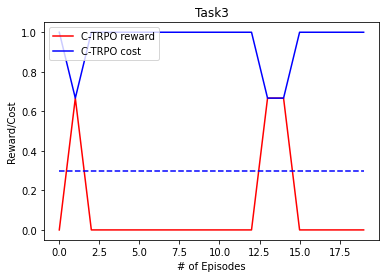

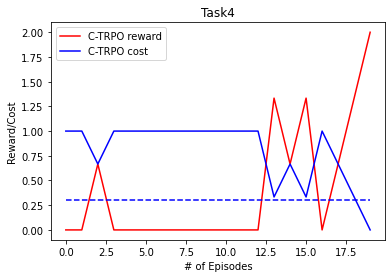

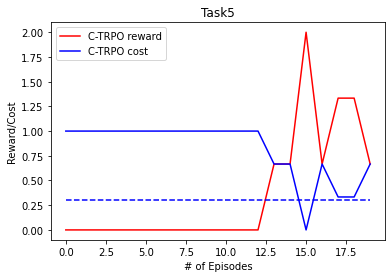

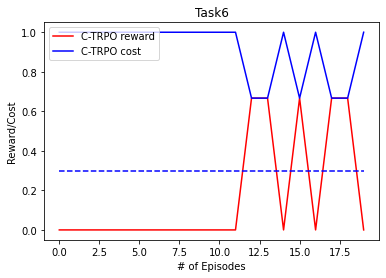

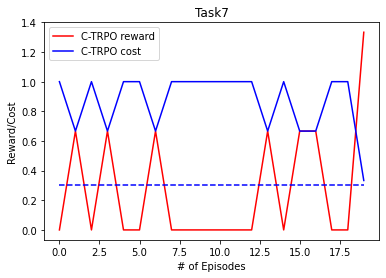

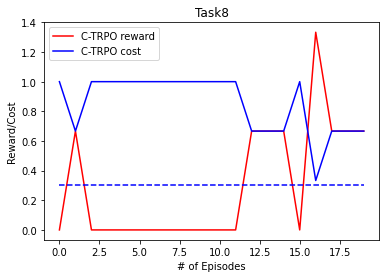

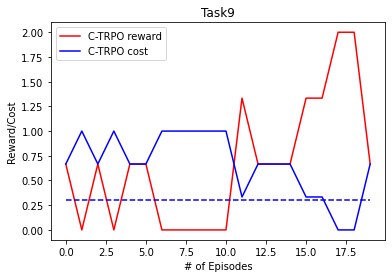

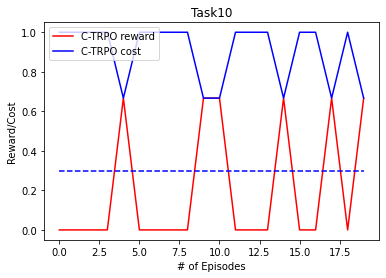

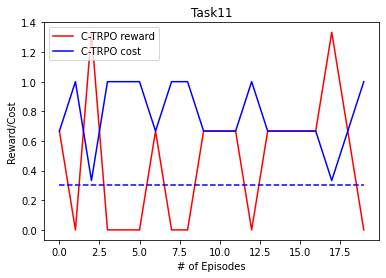

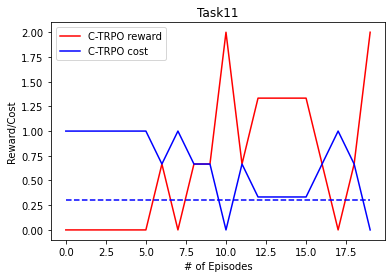

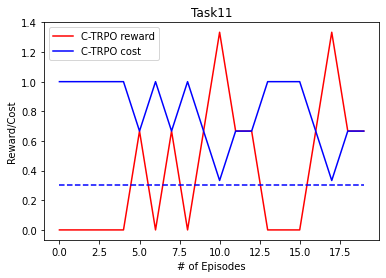

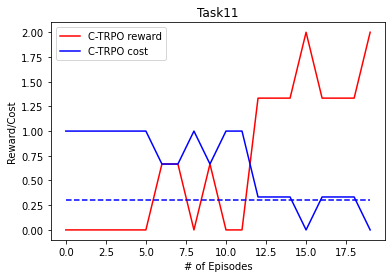

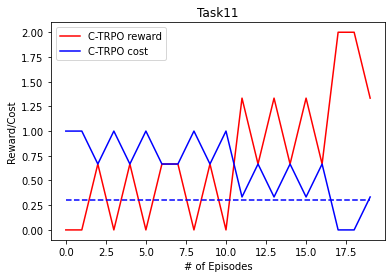

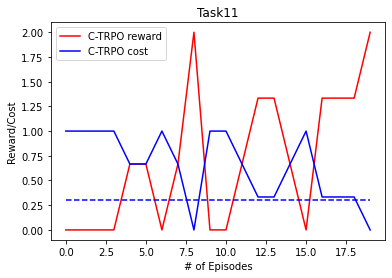

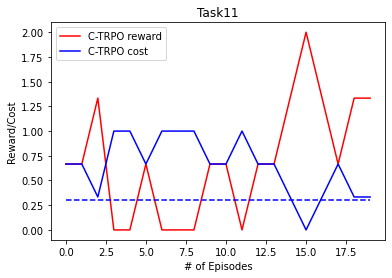

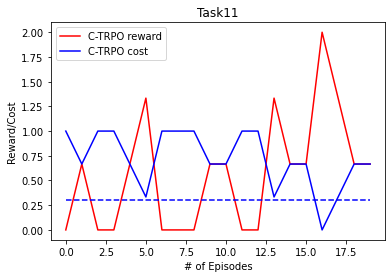

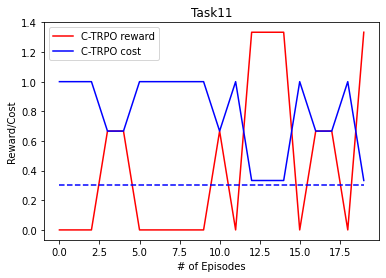

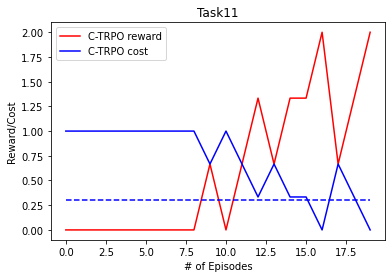

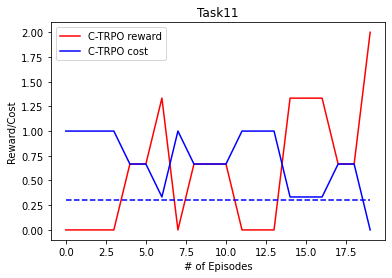

In [ ]:
num_tasks = 11

for i in range(num_tasks):
  if __name__ == '__main__':
    policy_model_out, results, violations = main(i+1)

    np.save('data_high_sim/Random_init/policy'+str(i+1), policy_model_out)    # .npy extension is added if not given
    
    # Run the policy on the test task for 10 runs to get the variance plots
    if (i+1) == 11:
      for j in range(10):
        policy_model_test, results_test, violations_test = main(i+1)
        np.save('data_high_sim/Test_task_data/Random_init/rewards_test'+str(j+1)+'.npy', results_test)
        np.save('data_high_sim/Test_task_data/Random_init/costs_test'+str(j+1)+'.npy', violations_test)


# Test strawman strategy on the new task

In [ ]:
def main(num_tasks, policies):
    # map_name = generate_random_map()
    # Giving a custom map
    map_name = np.load('maps_high_sim/map'+str(num_tasks)+'.npy')
    map_name = map_name.tolist()
    env = gym.make("FrozenLake-v1",desc= map_name, is_slippery=True)

    # np.save('map'+str(num_tasks)+'.npy', map_name)

    ## Hyperparameter
    beta = 0.3    # value function learning rate for the critic
    alpha = 0.03  # Keeping a constant learning rate
    gamma = 0.98             # Discount factor
    episodes = 3 #10        
    length = 100  #50       # Length of the sample trajectories, maybe we can change this

    STEP = 20

    # Set the threshold
    d_threshold = 0.3

    # Initialize the Q-tables and the policy for the task at hand
    qtable_reward = np.zeros((16, 4))
    qtable_cost = np.zeros((16, 4))

    if len(policies) == 0:
      policy_model = np.ones((16, 4))
    else:
      policy_model = policies[-1]


    N_0 = []

    ## Training the policy
    iterations = []
    results = []
    violations = []
    results_avg = []
    violations_avg = []
    result_avg = 0
    violation_avg = 0
  
    for iteration in range(STEP):
      result, violation, policy_model_out, value_model, cost_model = sample_trajectories(env, gamma, beta, episodes, length,
                                                                                         policy_model, qtable_reward, qtable_cost, d_threshold, N_0, alpha)

      
      
      policy_model = policy_model_out
      qtable_cost = cost_model
      qtable_reward = value_model


      iterations.append(iteration)
      results.append(result)
      violations.append(violation)


      result_avg = (iteration/(iteration+1)) * result_avg + (1/(iteration+1)) * result
      violation_avg = (iteration / (iteration + 1)) * violation_avg + (1 / (iteration + 1)) * (violation)
      

      results_avg.append(result_avg)
      violations_avg.append(violation_avg)


    constraint1 = [d_threshold for i in range(STEP)]
    # constraint2 = [d_threshold for i in range(STEP)]

    plt.figure()
    plt.plot(iterations, results, color='r', linestyle='-', label='C-TRPO reward')
    plt.plot(iterations, violations, color='b', linestyle='-', label='C-TRPO cost')
    
    # plt.plot(iterations, results_avg, color='r', linestyle='-.')
    # plt.plot(iterations, violations_avg, color='b', linestyle='-.')
    # # plt.plot(iterations, violations2_avg, color='g', linestyle='-.', label='C-TRPO average cost2')

    plt.plot(iterations, constraint1, color='b', linestyle='--')
    # plt.plot(iterations, constraint2, color='g', linestyle='--')
    plt.legend(loc='upper left')
    plt.xlabel('# of Episodes')
    plt.ylabel('Reward/Cost')
    plt.title('Task'+str(num_tasks))
    plt.show()
    # np.save('data_high_sim/rewards'+str(num_tasks)+'.npy',results)
    # np.save('data_high_sim/costs'+str(num_tasks)+'.npy',violations)

    orig_policy_model = softmax_policy_model_return(policy_model_out)

    return policy_model_out, results, violations

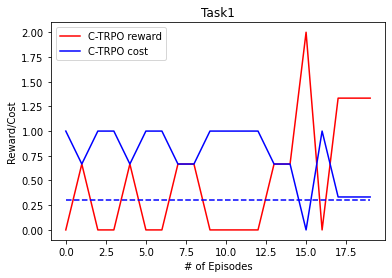

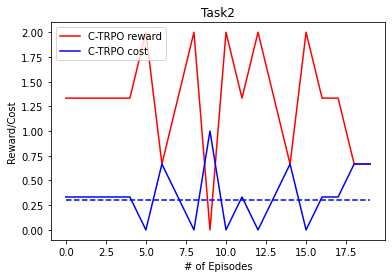

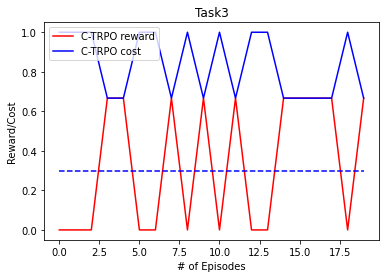

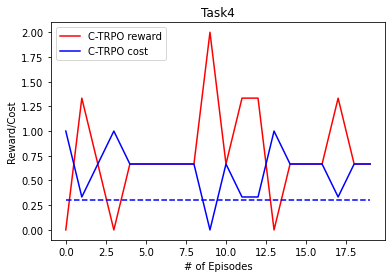

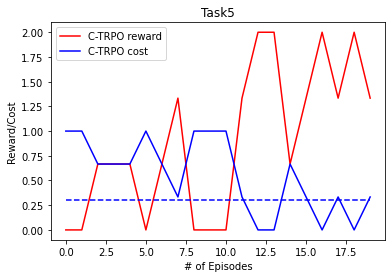

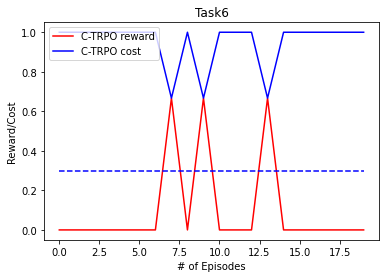

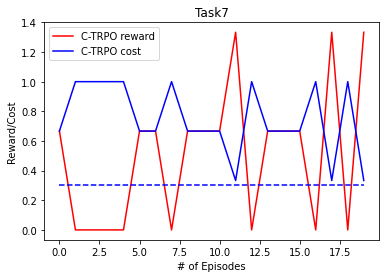

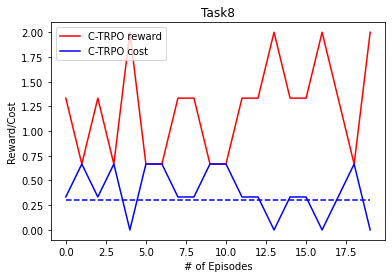

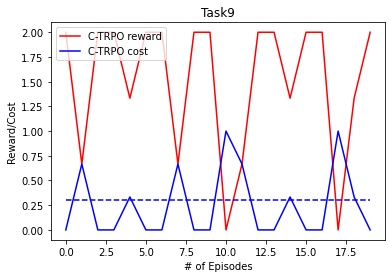

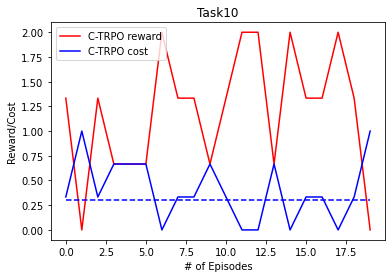

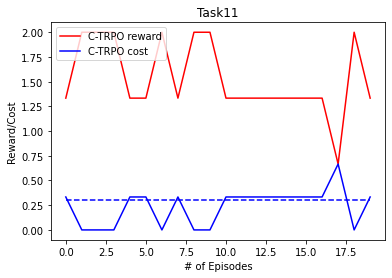

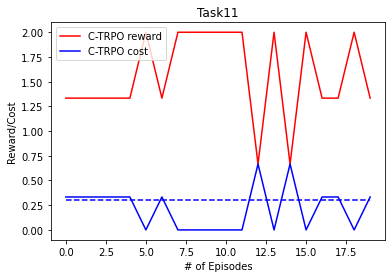

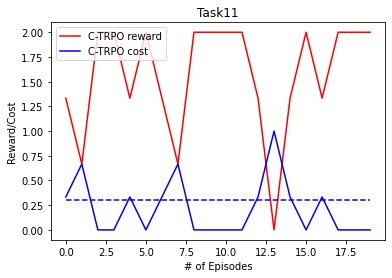

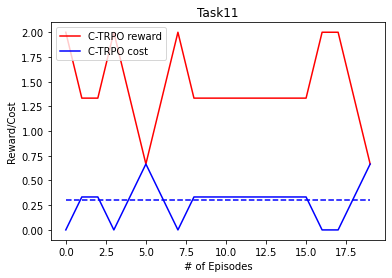

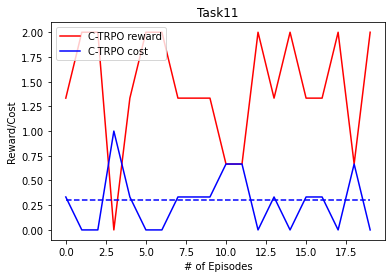

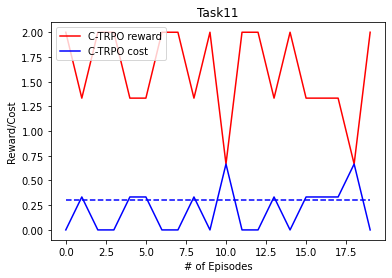

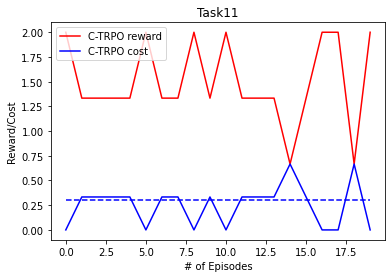

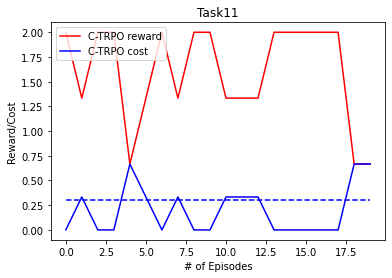

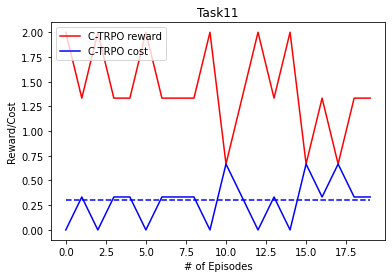

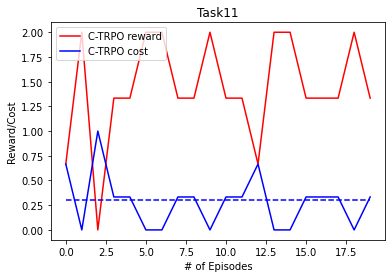

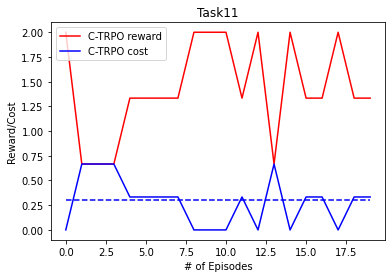

In [ ]:
num_tasks = 11

policies = []
for i in range(num_tasks):
  if __name__ == '__main__':
    policy_model_out, results, violations = main(i+1, policies)
    policies.append(policy_model_out)

    # Run the policy on the test task for 10 runs to get the variance plots
    if (i+1) == 11:
      policies = policies[:-1]
      for j in range(10):
        policy_model_test, results_test, violations_test = main(i+1, policies)
        np.save('data_high_sim/Test_task_data/Strawman/rewards_test'+str(j+1)+'.npy', results_test)
        np.save('data_high_sim/Test_task_data/Strawman/costs_test'+str(j+1)+'.npy', violations_test)

# Code for the FAL (online)

In [ ]:
def main(num_tasks, policies):
    # map_name = generate_random_map()
    # Giving a custom map
    map_name = np.load('maps_high_sim/map'+str(num_tasks)+'.npy')
    map_name = map_name.tolist()
    env = gym.make("FrozenLake-v1",desc= map_name, is_slippery=True)

    # np.save('map'+str(num_tasks)+'.npy', map_name)

    ## Hyperparameter
    beta = 0.3    # value function learning rate for the critic
    alpha = 0.03  # Keeping a constant learning rate
    gamma = 0.98             # Discount factor
    episodes = 10 #10        
    length = 100  #50       # Length of the sample trajectories, maybe we can change this

    STEP = 20

    # Set the threshold
    d_threshold = 0.3

    # Initialize the Q-tables and the policy for the task at hand
    qtable_reward = np.zeros((16, 4))
    qtable_cost = np.zeros((16, 4))

    if len(policies) == 0:
      policy_model = np.ones((16, 4))
    else:
      policies_arr = np.array(policies)
      policy_model = np.mean(policies_arr, axis = 0)


    N_0 = []

    ## Training the policy
    iterations = []
    results = []
    violations = []
    results_avg = []
    violations_avg = []
    result_avg = 0
    violation_avg = 0
  
    for iteration in range(STEP):
      result, violation, policy_model_out, value_model, cost_model = sample_trajectories(env, gamma, beta, episodes, length,
                                                                                         policy_model, qtable_reward, qtable_cost, d_threshold, N_0, alpha)

      
      
      policy_model = policy_model_out
      qtable_cost = cost_model
      qtable_reward = value_model


      iterations.append(iteration)
      results.append(result)
      violations.append(violation)


      result_avg = (iteration/(iteration+1)) * result_avg + (1/(iteration+1)) * result
      violation_avg = (iteration / (iteration + 1)) * violation_avg + (1 / (iteration + 1)) * (violation)
      

      results_avg.append(result_avg)
      violations_avg.append(violation_avg)


    constraint1 = [d_threshold for i in range(STEP)]
    # constraint2 = [d_threshold for i in range(STEP)]

    plt.figure()
    plt.plot(iterations, results, color='r', linestyle='-', label='C-TRPO reward')
    plt.plot(iterations, violations, color='b', linestyle='-', label='C-TRPO cost')
    
    # plt.plot(iterations, results_avg, color='r', linestyle='-.')
    # plt.plot(iterations, violations_avg, color='b', linestyle='-.')
    # # plt.plot(iterations, violations2_avg, color='g', linestyle='-.', label='C-TRPO average cost2')

    plt.plot(iterations, constraint1, color='b', linestyle='--')
    # plt.plot(iterations, constraint2, color='g', linestyle='--')
    plt.legend(loc='upper left')
    plt.xlabel('# of Episodes')
    plt.ylabel('Reward/Cost')
    plt.title('Task'+str(num_tasks))
    plt.show()
    # np.save('data_high_sim/rewards'+str(num_tasks)+'.npy',results)
    # np.save('data_high_sim/costs'+str(num_tasks)+'.npy',violations)

    orig_policy_model = softmax_policy_model_return(policy_model_out)

    return policy_model_out, results, violations


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


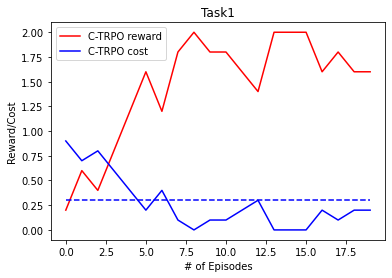

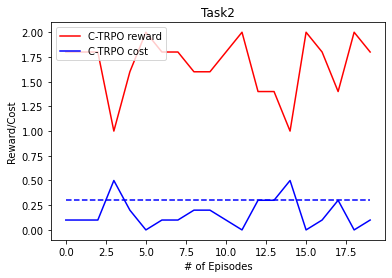

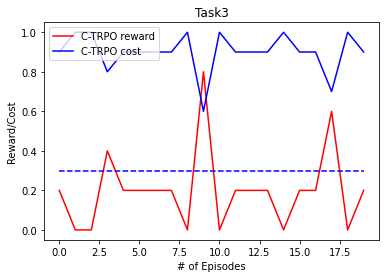

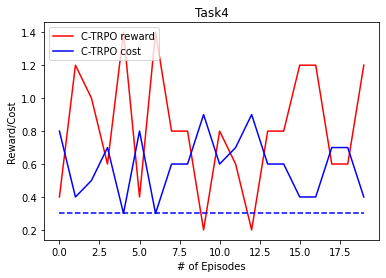

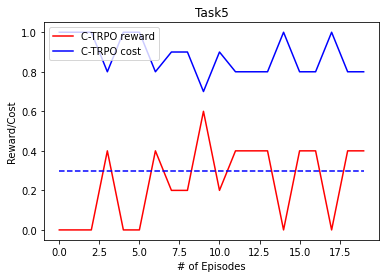

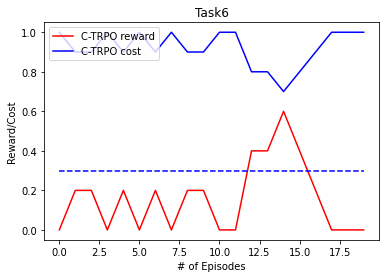

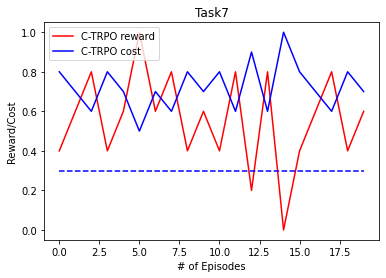

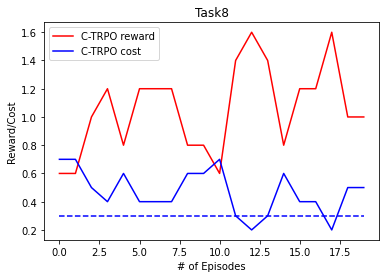

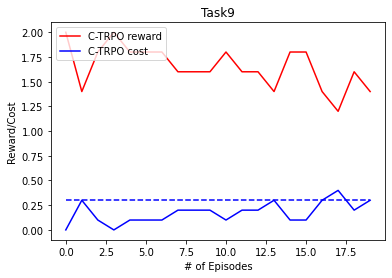

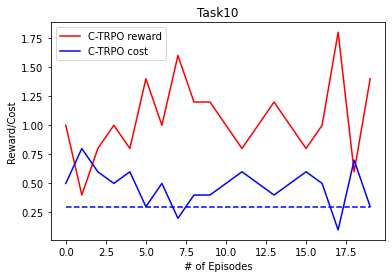

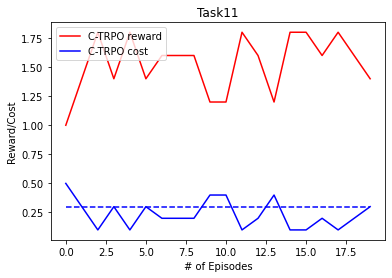

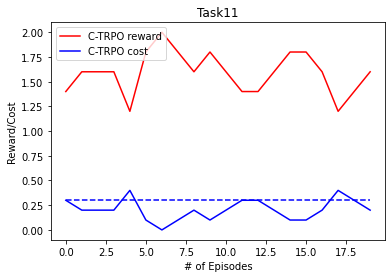

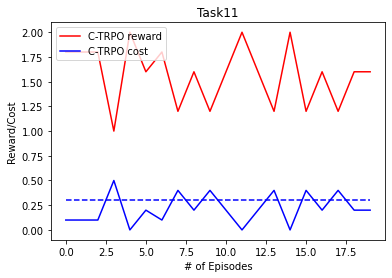

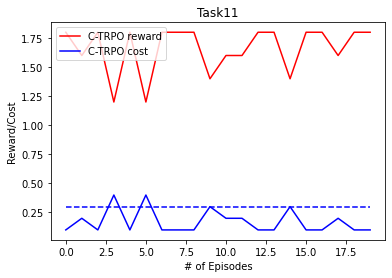

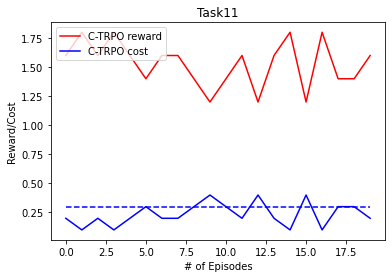

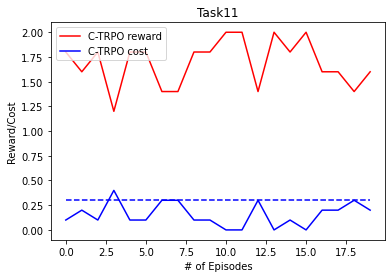

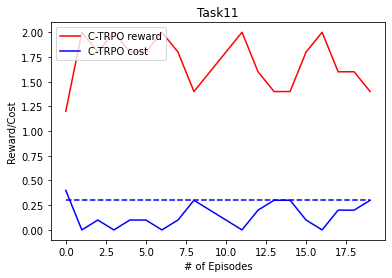

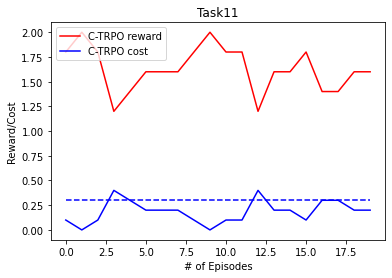

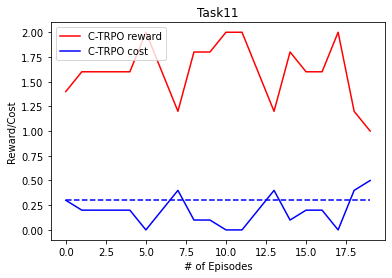

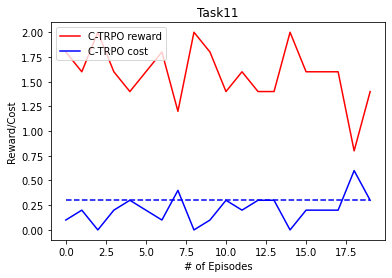

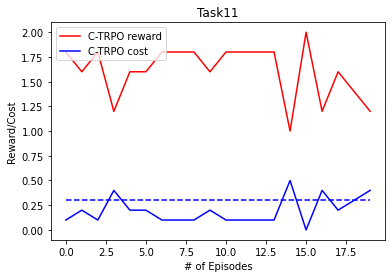

In [ ]:
num_tasks = 11

policies = []
for i in range(num_tasks):
  if __name__ == '__main__':
    policy_model_out, results, violations = main(i+1, policies)
    policies.append(policy_model_out)

    # Run the policy on the test task for 10 runs to get the variance plots
    if (i+1) == 11:
      policies = policies[:-1]
      for j in range(10):
        policy_model_test, results_test, violations_test = main(i+1, policies)
        np.save('data_high_sim/Test_task_data/FAL/rewards_test'+str(j+1)+'.npy', results_test)
        np.save('data_high_sim/Test_task_data/FAL/costs_test'+str(j+1)+'.npy', violations_test)



# Code for FAL (online) + adaptive learning rate

In [ ]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))


In [ ]:
def main(num_tasks, policies):
    # map_name = generate_random_map()
    # Giving a custom map
    map_name = np.load('maps_high_sim/map'+str(num_tasks)+'.npy')
    map_name = map_name.tolist()
    env = gym.make("FrozenLake-v1",desc= map_name, is_slippery=True)

    # np.save('map'+str(num_tasks)+'.npy', map_name)

    ## Hyperparameter
    beta = 0.3    # value function learning rate for the critic
    
    gamma = 0.98             # Discount factor
    episodes = 10 #10        
    length = 100  #50       # Length of the sample trajectories, maybe we can change this

    STEP = 20

    # Set the threshold
    d_threshold = 0.3

    # Initialize the Q-tables and the policy for the task at hand
    qtable_reward = np.zeros((16, 4))
    qtable_cost = np.zeros((16, 4))

    if len(policies) == 0:
      policy_model = np.ones((16, 4))
      alpha = 0.03
    else:
      policies_arr = np.array(policies)
      policy_model = np.mean(policies_arr, axis = 0)

      # Get the learning rate for this specific task
      M = STEP*episodes
      a= np.sqrt(1/num_tasks)
      b = np.sqrt(np.sqrt(1/M))
      # kl_divergence = np.mean(kl_data)
      alpha = (b)*np.sqrt(a)

    
    print('alpha = ',alpha)
    initial_policy = policy_model
    N_0 = []

    ## Training the policy
    iterations = []
    results = []
    violations = []
    results_avg = []
    violations_avg = []
    result_avg = 0
    violation_avg = 0
  
    for iteration in range(STEP):
      result, violation, policy_model_out, value_model, cost_model = sample_trajectories(env, gamma, beta, episodes, length,
                                                                                         policy_model, qtable_reward, qtable_cost, d_threshold, N_0, alpha)

      
      
      policy_model = policy_model_out
      qtable_cost = cost_model
      qtable_reward = value_model


      iterations.append(iteration)
      results.append(result)
      violations.append(violation)


      result_avg = (iteration/(iteration+1)) * result_avg + (1/(iteration+1)) * result
      violation_avg = (iteration / (iteration + 1)) * violation_avg + (1 / (iteration + 1)) * (violation)
      

      results_avg.append(result_avg)
      violations_avg.append(violation_avg)


    constraint1 = [d_threshold for i in range(STEP)]
    # constraint2 = [d_threshold for i in range(STEP)]

    plt.figure()
    plt.plot(iterations, results, color='r', linestyle='-', label='C-TRPO reward')
    plt.plot(iterations, violations, color='b', linestyle='-', label='C-TRPO cost')
    
    # plt.plot(iterations, results_avg, color='r', linestyle='-.')
    # plt.plot(iterations, violations_avg, color='b', linestyle='-.')
    # # plt.plot(iterations, violations2_avg, color='g', linestyle='-.', label='C-TRPO average cost2')

    plt.plot(iterations, constraint1, color='b', linestyle='--')
    # plt.plot(iterations, constraint2, color='g', linestyle='--')
    plt.legend(loc='upper left')
    plt.xlabel('# of Episodes')
    plt.ylabel('Reward/Cost')
    plt.title('Task'+str(num_tasks))
    plt.show()
    # np.save('data_high_sim/rewards'+str(num_tasks)+'.npy',results)
    # np.save('data_high_sim/costs'+str(num_tasks)+'.npy',violations)

    

    return policy_model_out, results, violations


alpha =  0.03


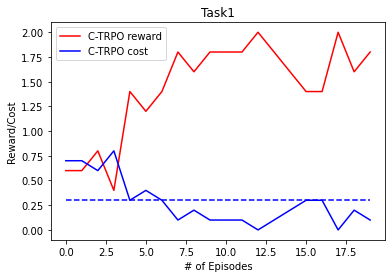

alpha =  0.223606797749979


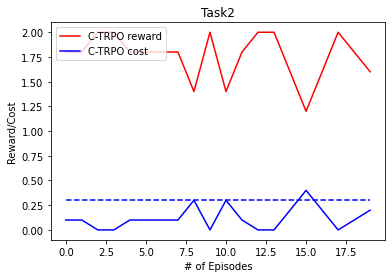

alpha =  0.20205155046766235


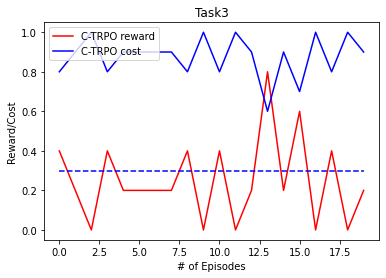

alpha =  0.18803015465431971


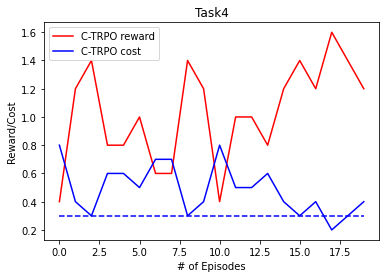

alpha =  0.1778279410038923


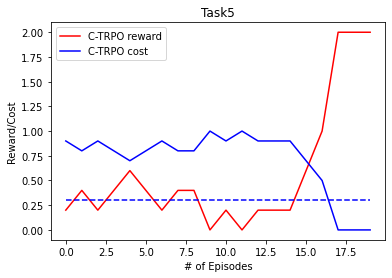

alpha =  0.16990442448471224


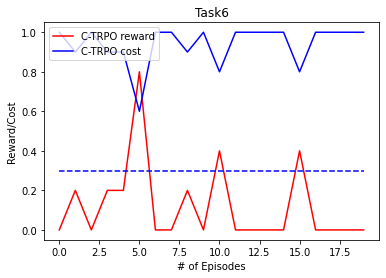

alpha =  0.16348126556655487


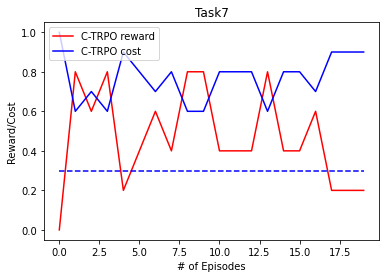

alpha =  0.15811388300841897


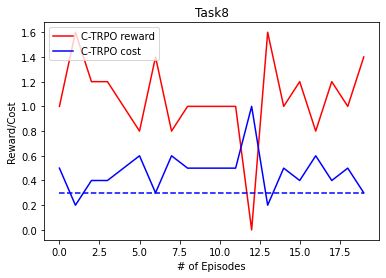

alpha =  0.15352597838656357


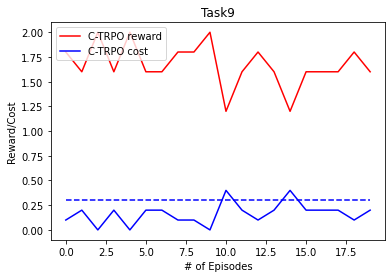

alpha =  0.14953487812212207


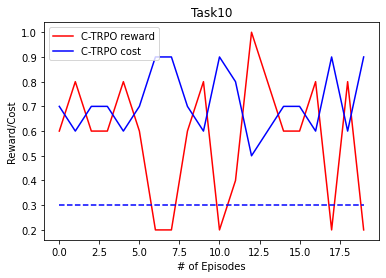

alpha =  0.14601394329159476


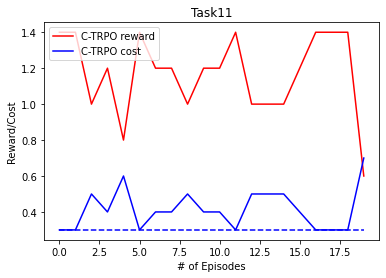

alpha =  0.14601394329159476


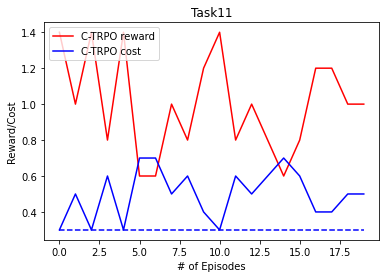

alpha =  0.14601394329159476


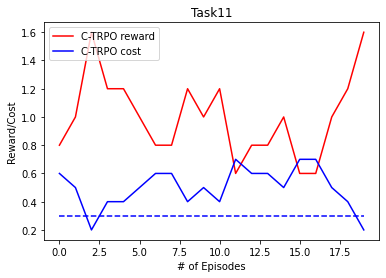

alpha =  0.14601394329159476


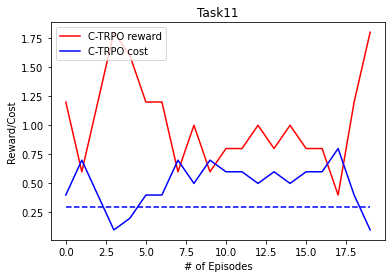

alpha =  0.14601394329159476


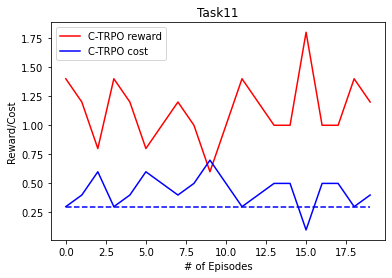

alpha =  0.14601394329159476


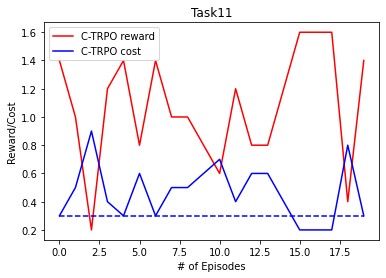

alpha =  0.14601394329159476


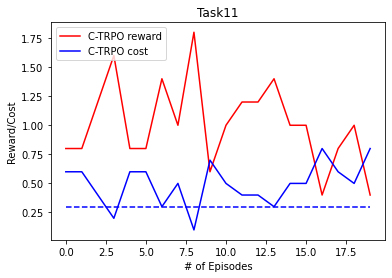

alpha =  0.14601394329159476


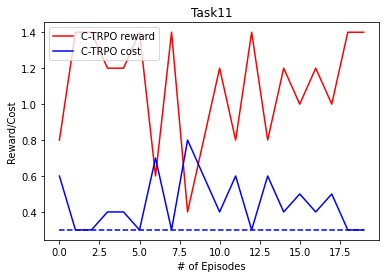

alpha =  0.14601394329159476


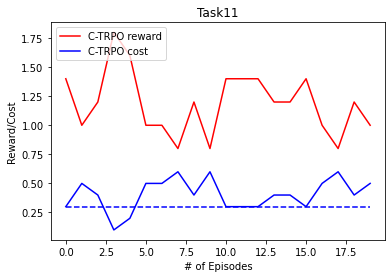

alpha =  0.14601394329159476


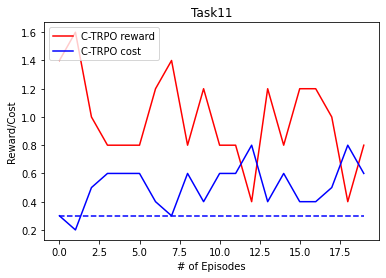

alpha =  0.14601394329159476


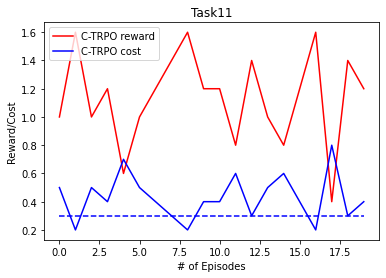

In [ ]:
num_tasks = 11

policies = []

for i in range(num_tasks):
  if __name__ == '__main__':
    policy_model_out, results, violations = main(i+1, policies)
    
    policies.append(policy_model_out)

    # Run the policy on the test task for 10 runs to get the variance plots
    if (i+1) == 11:
      policies = policies[:-1]
      for j in range(10):
        policy_model_test, results_test, violations_test = main(i+1, policies)
        np.save('data_high_sim/Test_task_data/FAL+adaptive/rewards_test'+str(j+1)+'.npy', results_test)
        np.save('data_high_sim/Test_task_data/FAL+adaptive/costs_test'+str(j+1)+'.npy', violations_test)


# Code for the weighted FAL

In [ ]:
def sample_trajectories_wo_update(env, gamma, beta, episodes, length, policy_model, qtable_reward, 
                        qtable_cost, d_threshold, N_0, alpha):
    # Sample trajectories
    paths = []
    episodes_so_far = 0
    k = 0

    while episodes_so_far < episodes:
        k += 1
        
        episodes_so_far += 1
        states, actions, rewards, costs = [], [], [], []
        state_action_buffer = []
        state = env.reset()
        length_so_far = 0
        done = False
        hole = False
        
        while not done:
        # while length_so_far < length:
          states.append(state)
          action = sample_actions(state, policy_model)
          new_state, done, hole = step(action, env)
          new_action = sample_actions(new_state, policy_model)
          actions.append(action)
  
          state_action_pair = [state, action]
          state_action_buffer.append(state_action_pair)
            
          reward = reward_function(new_state, env)
          cost = constraint_I(new_state, env)
  
          rewards.append(reward)
          costs.append(cost)
  
          # Update Q(s,a) for the reward
          qtable_reward[state, action] = qtable_reward[state, action] + \
                                  beta * (reward + gamma * qtable_reward[new_state, new_action] - qtable_reward[state, action])
  
          # Update Q(s,a) for the cost
          qtable_cost[state, action] = qtable_cost[state, action] + \
                                  beta * (cost + gamma * qtable_cost[new_state, new_action] - qtable_cost[state, action])
  
          # Update our current state
          state = new_state
          
          if done: 
            states.append(state)
            # alpha = alpha/(k**2)
            state = env.reset()

        path = {"observations": states,
                "actions": actions,
                "rewards": rewards,
                "costs": costs}
        paths.append(path)

        

    observations = flatten([path["observations"] for path in paths])
    discounted_rewards = flatten([math_utils.discount(path["rewards"], gamma) for path in paths])
    total_reward = sum(flatten([path["rewards"] for path in paths])) / episodes
    ## add for cost
    discounted_costs = flatten([math_utils.discount(path["costs"], gamma) for path in paths])
    total_cost = sum(flatten([path["costs"] for path in paths])) / episodes
    # discounted_costs2 = flatten([math_utils.discount(path["costs2"], gamma) for path in paths])
    # total_cost2 = sum(flatten([path["costs2"] for path in paths])) / episodes


    actions = flatten([path["actions"] for path in paths])

    return total_reward, total_cost, policy_model, observations
    

def get_weights(observations):

  counts = np.zeros(16)
  for i in range(len(observations)):
    val = observations[i]
    counts[val] = counts[val] + 1

  weights = counts/(len(observations))
  return weights

def get_weighted_policy(policies_arr, w, num_tasks):

  weighted_policy = np.zeros((16,4))
  for i in range(num_tasks-1):
    w[i] = w[i].reshape((16,1))
    weighted_policy = weighted_policy + (w[i]*policies_arr[i])
  
  w = np.array(w)
  # print(np.shape(w))
  for i in range(16):
    den = np.sum(w[:,i], axis=0)
    if den[0] == 0:
      weighted_policy[i,:] = weighted_policy[i,:]
    else:
      weighted_policy[i,:] = weighted_policy[i,:]/den[0]

  return weighted_policy

In [ ]:
def main(num_tasks, policies, w):
    # map_name = generate_random_map()
    # Giving a custom map
    map_name = np.load('maps_high_sim/map'+str(num_tasks)+'.npy')
    map_name = map_name.tolist()
    env = gym.make("FrozenLake-v1",desc= map_name, is_slippery=True)

    # np.save('map'+str(num_tasks)+'.npy', map_name)

    ## Hyperparameter
    beta = 0.3    # value function learning rate for the critic
    gamma = 0.98             # Discount factor
    episodes = 10 #10        
    length = 100  #50       # Length of the sample trajectories, maybe we can change this

    STEP = 20

    # Set the threshold
    d_threshold = 0.3

    # Initialize the Q-tables and the policy for the task at hand
    qtable_reward = np.zeros((16, 4))
    qtable_cost = np.zeros((16, 4))

    if len(policies) == 0:
      policy_model = np.ones((16, 4))
      alpha = 0.03
    else:
      policies_arr = np.array(policies)
      # policy_model = np.mean(policies_arr, axis = 0)
      # policy_model = np.average(policies_arr, axis = 0, weights = w)
      policy_model = get_weighted_policy(policies_arr, w, num_tasks)
      # Get the weighted average policy

      # Get the learning rate for this specific task
      M = STEP*episodes
      a= np.sqrt(1/num_tasks)
      b = np.sqrt(np.sqrt(1/M))
      # kl_divergence = np.mean(kl_data)
      # print('kl_divrgence = ', kl_divergence)
      alpha = (b)*np.sqrt(a)/1


    N_0 = []

    ## Training the policy
    iterations = []
    results = []
    violations = []
    results_avg = []
    violations_avg = []
    result_avg = 0
    violation_avg = 0
  
    for iteration in range(STEP):
      result, violation, policy_model_out, value_model, cost_model = sample_trajectories(env, gamma, beta, episodes, length,
                                                                                         policy_model, qtable_reward, qtable_cost, d_threshold, N_0, alpha)

      
      
      policy_model = policy_model_out
      qtable_cost = cost_model
      qtable_reward = value_model


      iterations.append(iteration)
      results.append(result)
      violations.append(violation)


      result_avg = (iteration/(iteration+1)) * result_avg + (1/(iteration+1)) * result
      violation_avg = (iteration / (iteration + 1)) * violation_avg + (1 / (iteration + 1)) * (violation)
      

      results_avg.append(result_avg)
      violations_avg.append(violation_avg)


    constraint1 = [d_threshold for i in range(STEP)]
    # constraint2 = [d_threshold for i in range(STEP)]

    plt.figure()
    plt.plot(iterations, results, color='r', linestyle='-', label='C-TRPO reward')
    plt.plot(iterations, violations, color='b', linestyle='-', label='C-TRPO cost')
    
    # plt.plot(iterations, results_avg, color='r', linestyle='-.')
    # plt.plot(iterations, violations_avg, color='b', linestyle='-.')
    # # plt.plot(iterations, violations2_avg, color='g', linestyle='-.', label='C-TRPO average cost2')

    plt.plot(iterations, constraint1, color='b', linestyle='--')
    # plt.plot(iterations, constraint2, color='g', linestyle='--')
    plt.legend(loc='upper left')
    plt.xlabel('# of Episodes')
    plt.ylabel('Reward/Cost')
    plt.title('Task'+str(num_tasks))
    plt.show()
    # np.save('data_high_sim/rewards'+str(num_tasks)+'.npy',results)
    # np.save('data_high_sim/costs'+str(num_tasks)+'.npy',violations)

    _, _, _, observations = sample_trajectories_wo_update(env, gamma, beta, 300, length,
                                                          policy_model_out, qtable_reward, qtable_cost, d_threshold, N_0, alpha)

    # Compute the weights for the weighted average
    weights = get_weights(observations)

    return policy_model_out, weights, results, violations


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


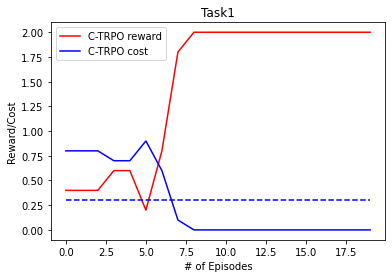

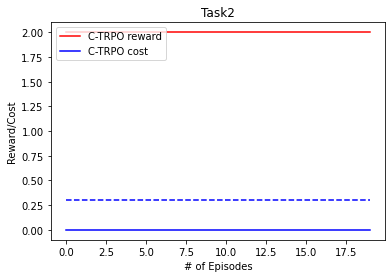

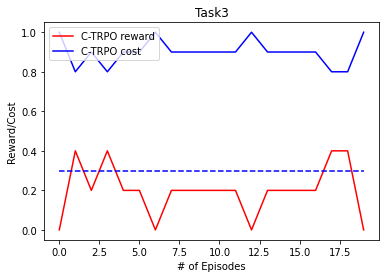

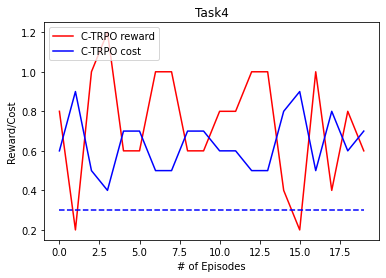

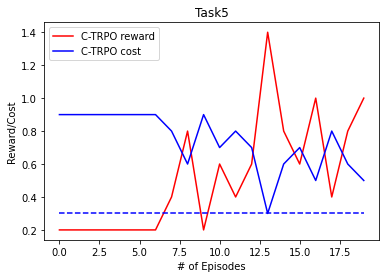

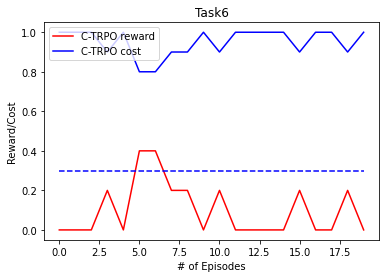

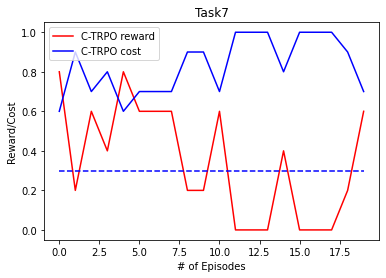

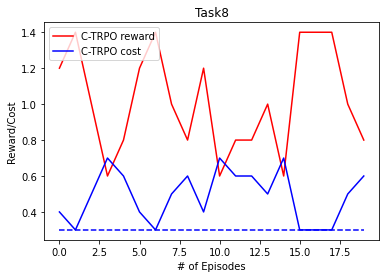

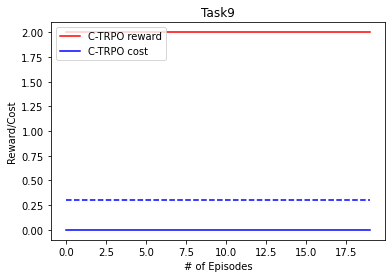

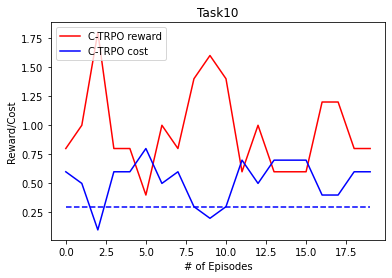

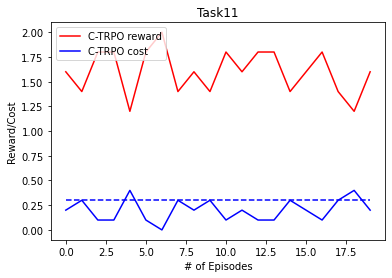

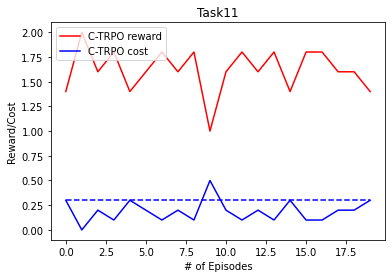

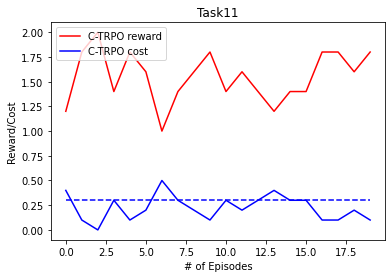

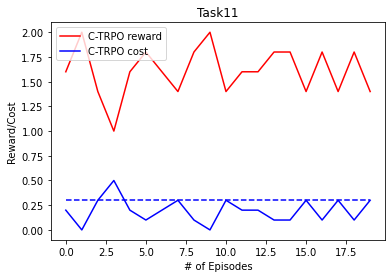

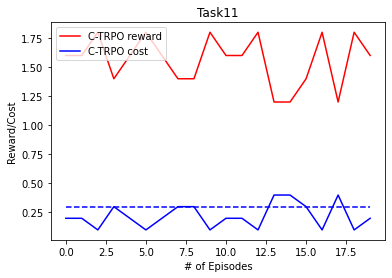

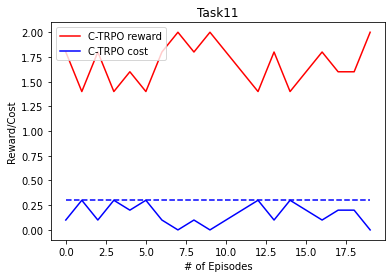

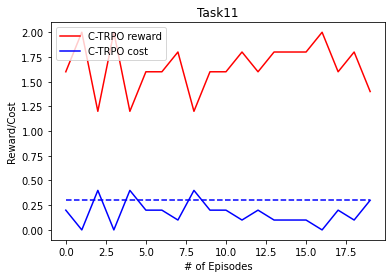

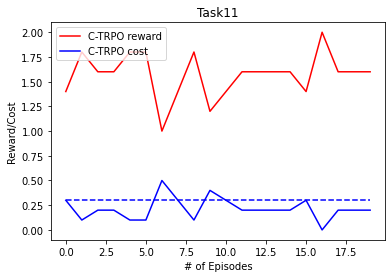

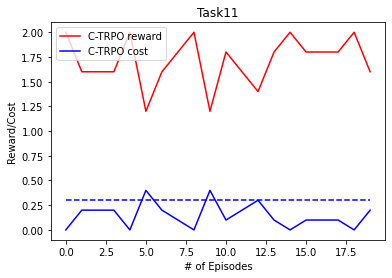

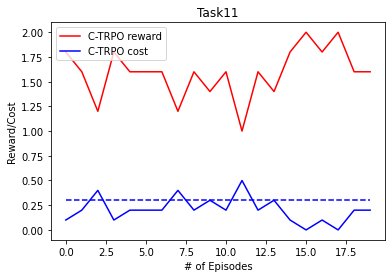

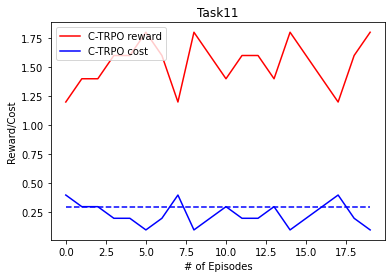

In [ ]:
num_tasks = 11

policies = []
w = []
for i in range(num_tasks):
  if __name__ == '__main__':
    policy_model_out, weights, results, violations = main(i+1, policies, w)

    w.append(weights)
    policies.append(policy_model_out)

    # Run the policy on the test task for 10 runs to get the variance plots
    if (i+1) == 11:
      policies = policies[:-1]
      w = w[:-1]
      for j in range(10):
        policy_model_test, weights, results_test, violations_test = main(i+1, policies, w)
        np.save('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test'+str(j+1)+'.npy', results_test)
        np.save('data_high_sim/Test_task_data/WFAL+adaptive/costs_test'+str(j+1)+'.npy', violations_test)


In [ ]:
# Get the random_init
a1 = np.load('data_high_sim/Test_task_data/Random_init/rewards_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/Random_init/rewards_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/Random_init/rewards_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/Random_init/rewards_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/Random_init/rewards_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/Random_init/rewards_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/Random_init/rewards_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/Random_init/rewards_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/Random_init/rewards_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/Random_init/rewards_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_random_init = np.mean(a, axis=0)
a_std_random_init = np.std(a, axis = 0)

# Get for strawman
a1 = np.load('data_high_sim/Test_task_data/Strawman/rewards_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/Strawman/rewards_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/Strawman/rewards_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/Strawman/rewards_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/Strawman/rewards_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/Strawman/rewards_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/Strawman/rewards_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/Strawman/rewards_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/Strawman/rewards_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/Strawman/rewards_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_strawman = np.mean(a, axis=0)
a_std_strawman = np.std(a, axis = 0)

# Get for FAL+adaptive learning rate
a1 = np.load('data_high_sim/Test_task_data/FAL+adaptive/rewards_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/FAL+adaptive/rewards_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/FAL+adaptive/rewards_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/FAL+adaptive/rewards_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/FAL+adaptive/rewards_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/FAL+adaptive/rewards_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/FAL+adaptive/rewards_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/FAL+adaptive/rewards_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/FAL+adaptive/rewards_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/FAL+adaptive/rewards_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_fal_adapt = np.mean(a, axis=0)
a_std_fal_adapt = np.std(a, axis = 0)

# Get for WFAL+adaptive learning rate
a1 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/rewards_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_wfal_adapt = np.mean(a, axis=0)
a_std_wfal_adapt = np.std(a, axis = 0)

# Get for FAL
a1 = np.load('data_high_sim/Test_task_data/FAL/rewards_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/FAL/rewards_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/FAL/rewards_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/FAL/rewards_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/FAL/rewards_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/FAL/rewards_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/FAL/rewards_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/FAL/rewards_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/FAL/rewards_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/FAL/rewards_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_fal = np.mean(a, axis=0)
a_std_fal = np.std(a, axis = 0)

# Get for simple averaging
a1 = np.load('data_high_sim/Test_task_data/Simple_averaging/rewards_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/Simple_averaging/rewards_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/Simple_averaging/rewards_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/Simple_averaging/rewards_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/Simple_averaging/rewards_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/Simple_averaging/rewards_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/Simple_averaging/rewards_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/Simple_averaging/rewards_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/Simple_averaging/rewards_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/Simple_averaging/rewards_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_sa = np.mean(a, axis=0)
a_std_sa = np.std(a, axis = 0)




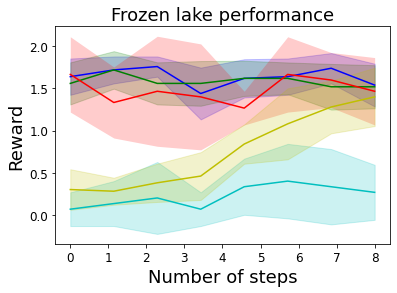

In [ ]:
# Plots code here for the frozen lake
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

x = np.linspace(0, 8, 8)
threshold = 0.3*np.ones(8)

f = plt.figure()
# Get the cost plots
plt.plot(x, a_mean_wfal_adapt[:8], 'g', label='Meta-SRL')
plt.plot(x, a_mean_fal[:8], 'b', label='FAL')
# plt.plot(x, a_mean_fal_adapt[:8], 'm', label='Meta-SRL1')
plt.plot(x, a_mean_strawman[:8], 'r', label='Pre-trained')
plt.plot(x, a_mean_random_init[:8], 'c', label='Random initialization')
plt.plot(x, a_mean_sa[:8], 'y', label='Simple averaging')

# plt.plot(x, threshold, 'k-', color='b', linestyle='--')
# plt.legend(loc='upper left')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Number of steps')
plt.ylabel('Reward')
plt.title('Frozen lake performance')

plt.fill_between(x, a_mean_fal[:8]-a_std_fal[:8], a_mean_fal[:8]+a_std_fal[:8],
                 alpha=0.2, color = 'b')
plt.fill_between(x, a_mean_wfal_adapt[:8]-a_std_wfal_adapt[:8], a_mean_wfal_adapt[:8]+a_std_wfal_adapt[:8],
    alpha=0.2, color = 'g')
# plt.fill_between(x, a_mean_fal_adapt-a_std_fal_adapt, a_mean_fal_adapt+a_std_fal_adapt,
#     alpha=0.2, color = 'm')
plt.fill_between(x, a_mean_strawman[:8]-a_std_strawman[:8], a_mean_strawman[:8]+a_std_strawman[:8] ,
    alpha=0.2, color = 'r',
    linewidth=0)

plt.fill_between(x, a_mean_random_init[:8] - a_std_random_init[:8], 
                 a_mean_random_init[:8] + a_std_random_init[:8], alpha=0.2,
    color = 'c')

plt.fill_between(x, a_mean_sa[:8] - a_std_sa[:8], 
                 a_mean_sa[:8] + a_std_sa[:8], alpha=0.2,
    color = 'y')
plt.show()

f.savefig("FrozenLake_reward_high.pdf", bbox_inches='tight')

In [ ]:
# Get the random_init
a1 = np.load('data_high_sim/Test_task_data/Random_init/costs_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/Random_init/costs_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/Random_init/costs_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/Random_init/costs_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/Random_init/costs_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/Random_init/costs_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/Random_init/costs_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/Random_init/costs_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/Random_init/costs_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/Random_init/costs_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_random_init = np.mean(a, axis=0)
a_std_random_init = np.std(a, axis = 0)

# Get for strawman
a1 = np.load('data_high_sim/Test_task_data/Strawman/costs_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/Strawman/costs_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/Strawman/costs_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/Strawman/costs_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/Strawman/costs_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/Strawman/costs_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/Strawman/costs_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/Strawman/costs_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/Strawman/costs_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/Strawman/costs_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_strawman = np.mean(a, axis=0)
a_std_strawman = np.std(a, axis = 0)

# Get for FAL+adaptive learning rate
a1 = np.load('data_high_sim/Test_task_data/FAL+adaptive/costs_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/FAL+adaptive/costs_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/FAL+adaptive/costs_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/FAL+adaptive/costs_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/FAL+adaptive/costs_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/FAL+adaptive/costs_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/FAL+adaptive/costs_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/FAL+adaptive/costs_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/FAL+adaptive/costs_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/FAL+adaptive/costs_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_fal_adapt = np.mean(a, axis=0)
a_std_fal_adapt = np.std(a, axis = 0)

# Get for WFAL+adaptive learning rate
a1 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/costs_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/costs_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/costs_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/costs_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/costs_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/costs_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/costs_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/costs_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/costs_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/WFAL+adaptive/costs_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_wfal_adapt = np.mean(a, axis=0)
a_std_wfal_adapt = np.std(a, axis = 0)

# Get for FAL
a1 = np.load('data_high_sim/Test_task_data/FAL/costs_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/FAL/costs_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/FAL/costs_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/FAL/costs_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/FAL/costs_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/FAL/costs_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/FAL/costs_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/FAL/costs_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/FAL/costs_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/FAL/costs_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_fal = np.mean(a, axis=0)
a_std_fal = np.std(a, axis = 0)

# Get for simple averaging
a1 = np.load('data_high_sim/Test_task_data/Simple_averaging/costs_test1.npy')
a2 = np.load('data_high_sim/Test_task_data/Simple_averaging/costs_test2.npy')
a3 = np.load('data_high_sim/Test_task_data/Simple_averaging/costs_test3.npy')
a4 = np.load('data_high_sim/Test_task_data/Simple_averaging/costs_test4.npy')
a5 = np.load('data_high_sim/Test_task_data/Simple_averaging/costs_test5.npy')
a6 = np.load('data_high_sim/Test_task_data/Simple_averaging/costs_test6.npy')
a7 = np.load('data_high_sim/Test_task_data/Simple_averaging/costs_test7.npy')
a8 = np.load('data_high_sim/Test_task_data/Simple_averaging/costs_test8.npy')
a9 = np.load('data_high_sim/Test_task_data/Simple_averaging/costs_test9.npy')
a10 = np.load('data_high_sim/Test_task_data/Simple_averaging/costs_test10.npy')

a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = np.vstack(a_tuple)

a_mean_sa = np.mean(a, axis=0)
a_std_sa = np.std(a, axis = 0)




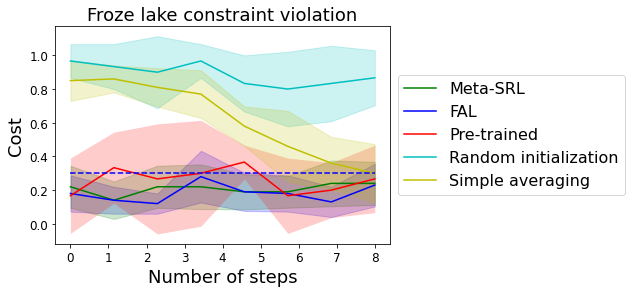

In [ ]:
# Plots code here for the frozen lake
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

x = np.linspace(0, 8,8)
threshold = 0.3*np.ones(8)

f = plt.figure()
# Get the cost plots
plt.plot(x, a_mean_wfal_adapt[:8], 'g', label='Meta-SRL')
plt.plot(x, a_mean_fal[:8], 'b', label='FAL')
# plt.plot(x, a_mean_fal_adapt, 'm', label='Meta-SRL1')
plt.plot(x, a_mean_strawman[:8], 'r', label='Pre-trained')
plt.plot(x, a_mean_random_init[:8], 'c', label='Random initialization')
plt.plot(x, a_mean_sa[:8], 'y', label='Simple averaging')

plt.plot(x, threshold, 'k-', color='b', linestyle='--')
# plt.legend(loc='upper left')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Number of steps')
plt.ylabel('Cost')
plt.title('Froze lake constraint violation')

plt.fill_between(x, a_mean_fal[:8]-a_std_fal[:8], a_mean_fal[:8]+a_std_fal[:8],
                 alpha=0.2, color = 'b')
plt.fill_between(x, a_mean_wfal_adapt[:8]-a_std_wfal_adapt[:8], a_mean_wfal_adapt[:8]+a_std_wfal_adapt[:8],
    alpha=0.2, color = 'g')
# plt.fill_between(x, a_mean_fal_adapt-a_std_fal_adapt, a_mean_fal_adapt+a_std_fal_adapt,
#     alpha=0.2, color = 'm')
plt.fill_between(x, a_mean_strawman[:8]-a_std_strawman[:8], a_mean_strawman[:8]+a_std_strawman[:8] ,
    alpha=0.2, color = 'r',
    linewidth=0)

plt.fill_between(x, a_mean_random_init[:8] - a_std_random_init[:8], 
                 a_mean_random_init[:8] + a_std_random_init[:8], alpha=0.2,
    color = 'c')

plt.fill_between(x, a_mean_sa[:8] - a_std_sa[:8], 
                 a_mean_sa[:8] + a_std_sa[:8], alpha=0.2,
    color = 'y')
plt.show()

f.savefig("FrozenLake_cost_high.pdf", bbox_inches='tight')

In [ ]:
# Load for the random init data initialization

# Get the random_init
a1 = np.load('data_high_sim/Random_init/policy1.npy')
a2 = np.load('data_high_sim/Random_init/policy2.npy')
a3 = np.load('data_high_sim/Random_init/policy3.npy')
a4 = np.load('data_high_sim/Random_init/policy4.npy')
a5 = np.load('data_high_sim/Random_init/policy5.npy')
a6 = np.load('data_high_sim/Random_init/policy6.npy')
a7 = np.load('data_high_sim/Random_init/policy7.npy')
a8 = np.load('data_high_sim/Random_init/policy8.npy')
a9 = np.load('data_high_sim/Random_init/policy9.npy')
a10 = np.load('data_high_sim/Random_init/policy10.npy')


# a_tuple = (a1,a2, a3,a4, a5, a6, a7, a8, a9, a10)
a = (a1+a2+a3+a4+a5+a6+a7+a8+a9+a10)/10

In [ ]:
def main(num_tasks, policy):
    # map_name = generate_random_map()
    # Giving a custom map
    map_name = np.load('maps_high_sim/map'+str(num_tasks)+'.npy')
    map_name = map_name.tolist()
    env = gym.make("FrozenLake-v1",desc= map_name, is_slippery=True)

    # np.save('map'+str(num_tasks)+'.npy', map_name)

    ## Hyperparameter
    beta = 0.3    # value function learning rate for the critic
    alpha = 0.03  # Keeping a constant learning rate
    gamma = 0.98             # Discount factor
    episodes = 10 #10        
    length = 100  #50       # Length of the sample trajectories, maybe we can change this

    STEP = 20

    # Set the threshold
    d_threshold = 0.3

    # Initialize the Q-tables and the policy for the task at hand
    qtable_reward = np.zeros((16, 4))
    qtable_cost = np.zeros((16, 4))
    policy_model = policy
    # policy_model = np.load('data_high_sim/policy8.npy')


    N_0 = []

    ## Training the policy
    iterations = []
    results = []
    violations = []
    results_avg = []
    violations_avg = []
    result_avg = 0
    violation_avg = 0
  
    for iteration in range(STEP):
      result, violation, policy_model_out, value_model, cost_model = sample_trajectories(env, gamma, beta, episodes, length,
                                                                                         policy_model, qtable_reward, qtable_cost, d_threshold, N_0, alpha)

      
      
      policy_model = policy_model_out
      qtable_cost = cost_model
      qtable_reward = value_model


      iterations.append(iteration)
      results.append(result)
      violations.append(violation)


      result_avg = (iteration/(iteration+1)) * result_avg + (1/(iteration+1)) * result
      violation_avg = (iteration / (iteration + 1)) * violation_avg + (1 / (iteration + 1)) * (violation)
      

      results_avg.append(result_avg)
      violations_avg.append(violation_avg)


    constraint1 = [d_threshold for i in range(STEP)]
    # constraint2 = [d_threshold for i in range(STEP)]

    plt.figure()
    plt.plot(iterations, results, color='r', linestyle='-', label='C-TRPO reward')
    plt.plot(iterations, violations, color='b', linestyle='-', label='C-TRPO cost')
    
    # plt.plot(iterations, results_avg, color='r', linestyle='-.')
    # plt.plot(iterations, violations_avg, color='b', linestyle='-.')
    # # plt.plot(iterations, violations2_avg, color='g', linestyle='-.', label='C-TRPO average cost2')

    plt.plot(iterations, constraint1, color='b', linestyle='--')
    # plt.plot(iterations, constraint2, color='g', linestyle='--')
    plt.legend(loc='upper left')
    plt.xlabel('# of Episodes')
    plt.ylabel('Reward/Cost')
    plt.title('Task'+str(num_tasks))
    plt.show()
    # np.save('data_high_sim/rewards'+str(num_tasks)+'.npy',results)
    # np.save('data_high_sim/costs'+str(num_tasks)+'.npy',violations)
    
    
    orig_policy_model = softmax_policy_model_return(policy_model_out)

    return policy_model_out, results, violations


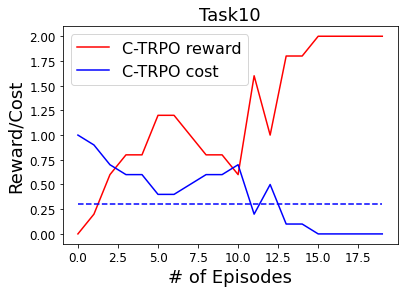

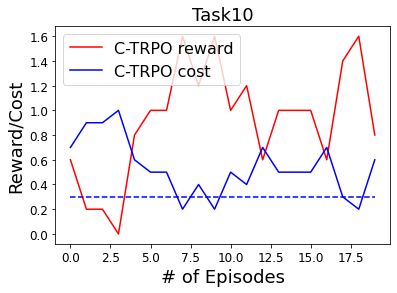

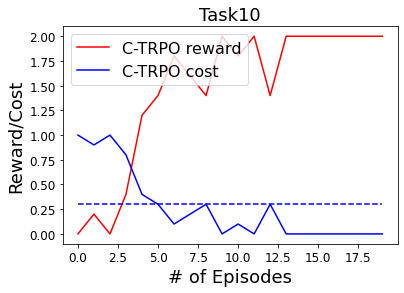

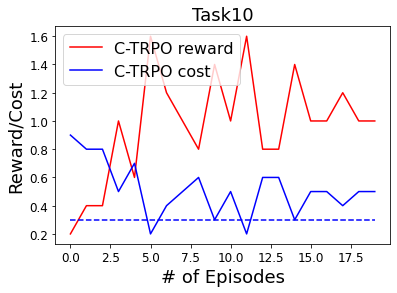

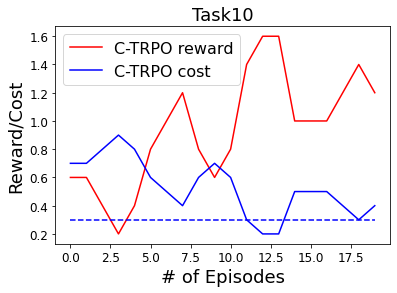

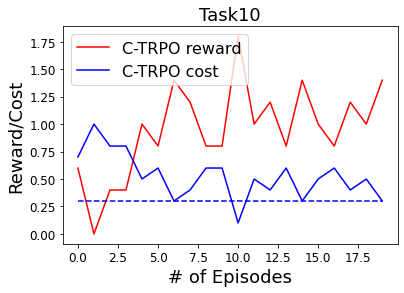

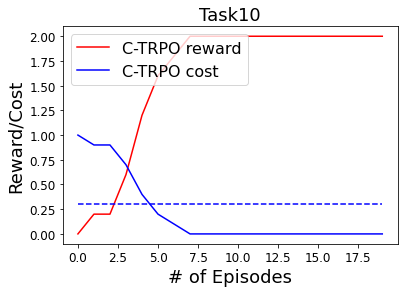

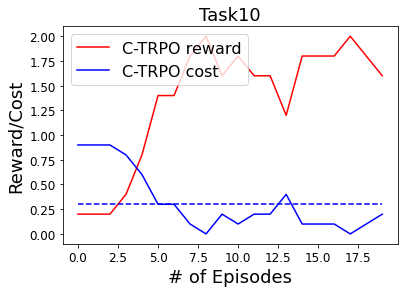

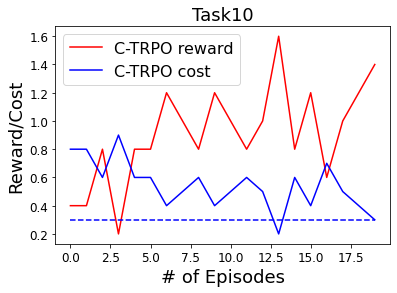

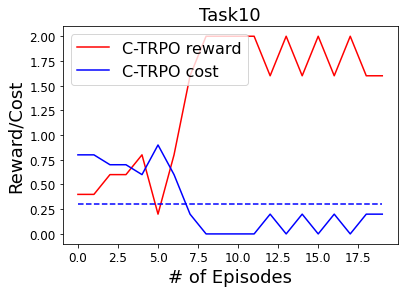

In [ ]:
policy = a
for i in range(10):
  policy = a
  if __name__ == '__main__':
      policy_model_test, results_test, violations_test = main(10, policy)
      np.save('data_high_sim/Test_task_data/Simple_averaging/rewards_test'+str(i+1)+'.npy', results_test)
      np.save('data_high_sim/Test_task_data/Simple_averaging/costs_test'+str(i+1)+'.npy', violations_test)

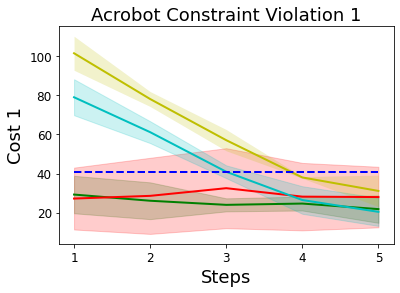

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plots code here for the frozen lake
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
x = np.linspace(1, 5, 5)
threshold = 41*np.ones(5)
f = plt.figure()
# Get the cost plots

strawman_mean = np.array([27.2000 ,  28.5800  , 32.5000 ,  28.1800   ,27.9600])
strawman_std = np.array([15.8207 ,  19.4632 ,  20.4535  , 17.2455   ,15.4878])

metasrl_mean = np.array([29.2400 ,  26.0800  , 23.9800,   24.6400  , 21.8000])
metasrl_std = np.array([9.5751 ,   9.4091   , 3.3365  ,  3.5487  ,  7.0043])

randominit_mean = np.array([79.0000  , 61.1500 ,  40.9000,   26.4500  , 20.4000])
randominit_std = np.array([9.1986 ,   5.6009  ,  3.2599  ,  7.0491   , 7.1833])

simpleaveraging_mean = np.array([101.5000 ,  78.1000  , 57.0500  , 38.0000 ,  31.1000])
simpleaveraging_std = np.array([8.6971  ,  3.8184  ,  5.4447  ,  0.4243  ,  8.0610])



plt.plot(x, metasrl_mean, 'g', label='Meta-SRL', linewidth = 2)
plt.plot(x, strawman_mean, 'r', label='Pre-trained', linewidth = 2)
plt.plot(x, simpleaveraging_mean, 'y', label='Simple Averaging', linewidth = 2)
plt.plot(x, randominit_mean, 'c', label='Random Initialization', linewidth = 2)
plt.plot(x, threshold, 'k-', color='b', linestyle='--', linewidth = 2)
# plt.legend(loc='upper left')
plt.xlabel('Steps')
plt.xticks([1,2,3,4,5])
plt.ylabel('Cost 1')

plt.title('Acrobot Constraint Violation 1')
plt.fill_between(x, metasrl_mean-metasrl_std, metasrl_mean+metasrl_std,
                 alpha=0.2, color = 'g')
plt.fill_between(x, strawman_mean-strawman_std, strawman_mean+strawman_std,
    alpha=0.2, color = 'r')
plt.fill_between(x, randominit_mean-randominit_std, randominit_mean+randominit_std,
    alpha=0.2, color = 'c')
plt.fill_between(x, simpleaveraging_mean-simpleaveraging_std, simpleaveraging_mean+simpleaveraging_std ,
    alpha=0.2, color = 'y',
    linewidth=0)

plt.show()

f.savefig("Acrobot_cost1_high.pdf", bbox_inches='tight')

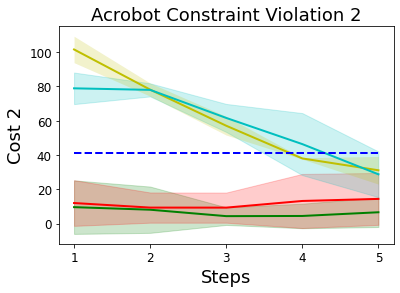

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plots code here for the frozen lake
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
x = np.linspace(1, 5, 5)
threshold = 41*np.ones(5)
f = plt.figure()
# Get the cost plots

strawman_mean = np.array([12.0200  ,  9.3600 ,   9.3400 ,  13.2200  , 14.4200])
strawman_std = np.array([13.3108  ,  8.8047 ,  8.7797 ,  15.7589 ,  15.1176])

metasrl_mean = np.array([9.6200  ,  8.1200 ,   4.3800 ,   4.4800  ,  6.6400])
metasrl_std = np.array([15.5996  , 13.4877  ,  5.1261 ,   7.1542 ,   8.6002])

randominit_mean = np.array([78.8500   ,77.9500 ,  61.6000 ,  46.3500  , 28.7500])
randominit_std = np.array([9.1933  ,  3.8066   , 8.1617  , 18.0690 ,  13.2950])

simpleaveraging_mean = np.array([101.5000 ,  78.1000  , 57.0500   ,38.0000 ,  31.1000])
simpleaveraging_std = np.array([7.6971  ,  3.8184   , 5.4447  ,  0.4243 ,   8.0610])


plt.plot(x, metasrl_mean, 'g', label='Meta-SRL', linewidth = 2)
plt.plot(x, strawman_mean, 'r', label='Pre-trained', linewidth = 2)
plt.plot(x, simpleaveraging_mean, 'y', label='Simple Averaging', linewidth = 2)
plt.plot(x, randominit_mean, 'c', label='Random Initialization', linewidth = 2)
plt.plot(x, threshold, 'k-', color='b', linestyle='--', linewidth = 2)
# plt.legend(loc='upper left')
plt.xlabel('Steps')
plt.xticks([1,2,3,4,5])
plt.ylabel('Cost 2')

plt.title('Acrobot Constraint Violation 2')
plt.fill_between(x, metasrl_mean-metasrl_std, metasrl_mean+metasrl_std,
                 alpha=0.2, color = 'g')
plt.fill_between(x, strawman_mean-strawman_std, strawman_mean+strawman_std,
    alpha=0.2, color = 'r')
plt.fill_between(x, randominit_mean-randominit_std, randominit_mean+randominit_std,
    alpha=0.2, color = 'c')
plt.fill_between(x, simpleaveraging_mean-simpleaveraging_std, simpleaveraging_mean+simpleaveraging_std ,
    alpha=0.2, color = 'y',
    linewidth=0)

plt.show()

f.savefig("Acrobot_cost2_high.pdf", bbox_inches='tight')

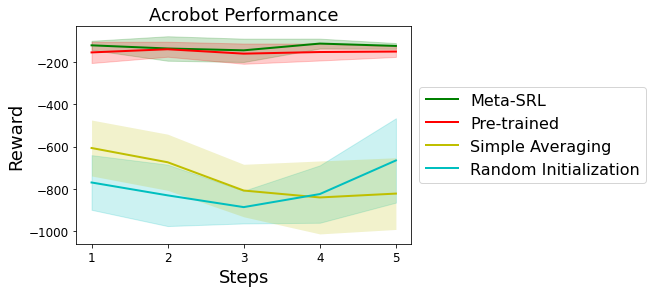

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plots code here for the frozen lake
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
x = np.linspace(1, 5, 5)
# threshold = 0.3*np.ones(5)
f = plt.figure()
# Get the cost plots

strawman_mean = np.array([-152.6889 ,-137.6729, -158.5928, -150.8850 ,-148.6249])
strawman_std = np.array([50.3519  , 35.5941  , 48.0353 ,  40.2142 ,  25.6368])

metasrl_mean = np.array([-119.0891 ,-134.0857, -142.7772 ,-110.7434 ,-121.8776])
metasrl_std = np.array([21.5400 ,  58.1572 ,  55.4051 ,  23.4499  , 13.5778])

randominit_mean = np.array([-770.3720, -831.5269 ,-887.3376 ,-825.3533 ,-665.6866])
randominit_std = np.array([129.7546 , 145.7652 ,  77.4783 , 136.2533 , 200.1922])

simpleaveraging_mean = np.array([-606.6243 ,-674.3022 ,-808.6485, -841.4112, -823.0950])
simpleaveraging_std = np.array([132.8071 , 133.3286 , 124.6637,  173.1861 , 170.2514])

plt.plot(x, metasrl_mean, 'g', label='Meta-SRL' , linewidth = 2)
plt.plot(x, strawman_mean, 'r', label='Pre-trained', linewidth = 2)
plt.plot(x, simpleaveraging_mean, 'y', label='Simple Averaging', linewidth = 2)
plt.plot(x, randominit_mean, 'c', label='Random Initialization', linewidth = 2)
# plt.plot(x, threshold, 'k-', color='b', linestyle='--')
# plt.legend(loc='upper left')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Steps')
plt.xticks([1,2,3,4,5])
plt.ylabel('Reward')
plt.yticks(np.linspace(-1000, 0, 6))

plt.title('Acrobot Performance')
plt.fill_between(x, metasrl_mean-metasrl_std, metasrl_mean+metasrl_std,
                 alpha=0.2, color = 'g')
plt.fill_between(x, strawman_mean-strawman_std, strawman_mean+strawman_std,
    alpha=0.2, color = 'r')
plt.fill_between(x, randominit_mean-randominit_std, randominit_mean+randominit_std,
    alpha=0.2, color = 'c')
plt.fill_between(x, simpleaveraging_mean-simpleaveraging_std, simpleaveraging_mean+simpleaveraging_std ,
    alpha=0.2, color = 'y',
    linewidth=0)

plt.show()

f.savefig("Acrobot_reward_high.pdf", bbox_inches='tight')